In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
import seaborn as sns
import sys
import os
import copy
from adjustText import adjust_text

sys.path.append("/disk212/yupf/code/HLCA_reproducibility/scripts")
import utils2
import analysis

from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import entropy

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
path_HLCA = "/disk212/yupf/database/scRNA-seq/NewAtlas/atlas_level3_v3.h5ad"
dir_results = "/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/proportion_cov/"
dir_figures = "/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/proportion_cov/figures/"

In [3]:
adata = sc.read(path_HLCA)

In [8]:
depth_meta=pd.read_csv('/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/other_cov/depth_meta.txt',sep='\t')
depth_meta['Sequencing Saturation']= depth_meta['Sequencing Saturation']/100
map1=dict(zip(depth_meta['sample'],depth_meta['Sequencing Saturation']))
adata.obs['Sequencing_Saturation']=adata.obs['Dataset'].map(map1)

In [11]:
min_n_cells_total = 50  # in total
min_n_cells = 10  # per sample
min_n_samples = 2

In [9]:
# 初始化字典，存储每次回归中包含的样本
samples_included = dict()
cts_to_skip = list()  # 储存样本太少需要跳过的细胞类型

# 计算每个样本中各细胞类型的比例
def calculate_cell_proportions(adata, celltype_col='Lineage', sample_col='project'):
    """
    计算每个样本中各细胞类型的比例
    """
    # 计算每个样本-细胞类型组合的细胞数
    sample_celltype_counts = adata.obs.groupby([sample_col, celltype_col]).size().unstack(fill_value=0)
    
    # 计算每个样本的总细胞数
    sample_total_counts = sample_celltype_counts.sum(axis=1)
    
    # 计算比例
    sample_celltype_proportions = sample_celltype_counts.div(sample_total_counts, axis=0)
    
    return sample_celltype_proportions

# 计算细胞比例
cell_proportions = calculate_cell_proportions(adata, celltype_col='Lineage', sample_col='project')

# 获取所有细胞类型
all_celltypes = cell_proportions.columns.tolist()

print(f"分析 {len(all_celltypes)} 个细胞类型的比例变异...")
print(f"细胞类型: {all_celltypes}")

covariates = [ 'total_counts','doublet_score','Sequencing_Saturation','pct_counts_mt', 'segment', 'stage', 'weaned', 'phase', 'gender', 'region', 'breed']

# 为每个细胞类型进行回归分析
for celltype in all_celltypes:
    celltype_no_space = celltype.replace(" ", "_").replace("/", "_")
    
    # 初始化存储每个协变量包含样本信息的DataFrame
    samples_included[celltype] = pd.DataFrame(
        index=adata.obs["project"].unique(), columns=covariates
    )
    
    # 检查输出文件是否已存在
    output_file = os.path.join(
        dir_results,
        f"proportion_variance_explained/proportion_variance_explained_{celltype_no_space}.csv"
    )
    
    if not os.path.isfile(output_file):
        print(f"正在分析细胞类型: {celltype}...")
        
        # 获取该细胞类型的比例数据
        celltype_proportions = cell_proportions[celltype]
        
        # 检查有足够细胞的样本数量
        # 这里我们检查比例大于某个阈值(如0.001)的样本数
        min_proportion_threshold = 0.001  # 可根据需要调整
        valid_samples = celltype_proportions[celltype_proportions > min_proportion_threshold]
        
        if len(valid_samples) < min_n_samples:
            print(f"细胞类型 {celltype} 在足够样本中的比例太低 (只有{len(valid_samples)}个样本). 跳过.")
            cts_to_skip.append(celltype)
            continue
        
        # 创建样本级别的数据框，包含比例和协变量
        sample_df = pd.DataFrame(index=valid_samples.index)
        sample_df['proportion'] = valid_samples
        
        # 添加协变量信息
        for cov in covariates:
            if cov in ['total_counts', 'pct_counts_mt','doublet_score']:
                # 对于细胞级别的协变量，取样本内的平均值
                sample_means = adata.obs.groupby('project')[cov].mean()
                sample_df[cov] = sample_means.reindex(sample_df.index)
            else:
                # 对于样本级别的协变量，直接使用
                sample_covariates = adata.obs.groupby('project')[cov].first()
                sample_df[cov] = sample_covariates.reindex(sample_df.index)
        
        # 过滤掉总细胞数少于最小要求的样本
        sample_cell_counts = adata.obs.groupby('project').size()
        sample_df['n_cells'] = sample_cell_counts.reindex(sample_df.index)
        sample_df = sample_df.loc[sample_df.n_cells >= min_n_cells].copy()
        
        # 再次检查样本数量
        if sample_df.shape[0] < min_n_samples:
            print(f"过滤后只有 {sample_df.shape[0]} 个样本可用于 {celltype}. 跳过.")
            cts_to_skip.append(celltype)
            continue
        
        # 初始化存储方差解释结果的Series
        var_explained = pd.Series(index=covariates + ["overall"], dtype=float)
        
        # 获取比例数据作为因变量
        y_true_unfiltered = sample_df['proportion'].values
        
        # 存储总方差
        var_explained['overall'] = np.var(y_true_unfiltered)
        
        # 对每个协变量进行线性回归
        for cov in covariates:
            # 获取协变量数据
            x = sample_df[cov].values.copy()
            x_samples = sample_df.index
            
            # 检查缺失值
            x_nans = np.vectorize(utils2.check_if_nan)(x)  # 假设utils2.check_if_nan函数存在
            # 如果没有utils2，可以用这个简单版本：
            # x_nans = pd.isna(x)
            
            # 过滤掉缺失值
            x = x[~x_nans]
            
            if len(x) < 2:
                var_explained[cov] = np.nan
                continue
            
            # 过滤样本和因变量
            x_samples = x_samples[~x_nans]
            samples_included[celltype][cov] = samples_included[celltype].index.isin(x_samples.tolist())
            y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
            
            # 准备自变量用于线性回归
            if x.dtype in ["float32", "float", "float64"]:
                x = x.reshape(-1, 1)
                print(f"将 {cov} 作为连续变量处理")
            else:
                # 分类变量处理
                if len(set(x)) == 1:
                    var_explained[cov] = np.nan
                    continue
                
                print(f"将 {cov} 转换为哑变量")
                x = pd.get_dummies(x, drop_first=True)
            
            # 执行线性回归
            try:
                lrf = LinearRegression(fit_intercept=True).fit(x, y_true)
                y_pred = lrf.predict(x)
                var_explained[cov] = np.var(y_pred)
            except Exception as e:
                print(f"回归失败 for {cov}: {e}")
                var_explained[cov] = np.nan
        
        # 计算方差解释比例
        total_variance_explained = var_explained.copy()
        total_variance_explained_fractions = total_variance_explained / total_variance_explained["overall"]
        
        # 按解释方差大小排序
        total_variance_explained_fractions = total_variance_explained_fractions.drop('overall').sort_values(ascending=False)
        
        # 保存结果
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        total_variance_explained_fractions.to_csv(output_file)
        
        # 保存包含的样本信息
        samples_file = os.path.join(
            dir_results,
            f"proportion_samples_included/proportion_samples_included_{celltype_no_space}.csv"
        )
        os.makedirs(os.path.dirname(samples_file), exist_ok=True)
        samples_included[celltype].to_csv(samples_file)
        
        print(f"完成 {celltype} 的分析")
        print(f"解释方差最多的协变量: {total_variance_explained_fractions.index[0]} "
              f"({total_variance_explained_fractions.iloc[0]:.3f})")

print(f"\n分析完成!")
print(f"跳过的细胞类型 (样本不足): {cts_to_skip}")

/tmp/ipykernel_2624441/1611524362.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_celltype_counts = adata.obs.groupby([sample_col, celltype_col]).size().unstack(fill_value=0)
/tmp/ipykernel_2624441/1611524362.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_means = adata.obs.groupby('project')[cov].mean()
/tmp/ipykernel_2624441/1611524362.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_

分析 8 个细胞类型的比例变异...
细胞类型: ['Epithelial lineage', 'B lineage', 'T/ILC lineage', 'Myeloid lineage', 'Endothelial lineage', 'Mesenchymal lineage', 'Neuron Lineage', 'Red blood']
正在分析细胞类型: Epithelial lineage...
将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 Sequencing_Saturation 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 weaned 转换为哑变量
将 phase 转换为哑变量
将 gender 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 Epithelial lineage 的分析
解释方差最多的协变量: pct_counts_mt (0.523)
正在分析细胞类型: B lineage...


/tmp/ipykernel_2624441/1611524362.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_means = adata.obs.groupby('project')[cov].mean()
/tmp/ipykernel_2624441/1611524362.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('project')[cov].first()
/tmp/ipykernel_2624441/1611524362.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_means = adata.obs.groupby('project')[c

将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 Sequencing_Saturation 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 weaned 转换为哑变量
将 phase 转换为哑变量
将 gender 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 B lineage 的分析
解释方差最多的协变量: segment (0.463)
正在分析细胞类型: T/ILC lineage...
将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 Sequencing_Saturation 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 weaned 转换为哑变量
将 phase 转换为哑变量
将 gender 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 T/ILC lineage 的分析
解释方差最多的协变量: breed (0.410)


/tmp/ipykernel_2624441/1611524362.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('project')[cov].first()
/tmp/ipykernel_2624441/1611524362.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('project')[cov].first()
/tmp/ipykernel_2624441/1611524362.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('

正在分析细胞类型: Myeloid lineage...
将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 Sequencing_Saturation 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 weaned 转换为哑变量
将 phase 转换为哑变量
将 gender 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 Myeloid lineage 的分析
解释方差最多的协变量: breed (0.271)
正在分析细胞类型: Endothelial lineage...


/tmp/ipykernel_2624441/1611524362.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_means = adata.obs.groupby('project')[cov].mean()
/tmp/ipykernel_2624441/1611524362.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_means = adata.obs.groupby('project')[cov].mean()
/tmp/ipykernel_2624441/1611524362.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('project')[co

将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 Sequencing_Saturation 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 weaned 转换为哑变量
将 phase 转换为哑变量
将 gender 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 Endothelial lineage 的分析
解释方差最多的协变量: gender (0.142)
正在分析细胞类型: Mesenchymal lineage...
将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 Sequencing_Saturation 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 weaned 转换为哑变量
将 phase 转换为哑变量
将 gender 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 Mesenchymal lineage 的分析
解释方差最多的协变量: breed (0.427)
正在分析细胞类型: Neuron Lineage...


/tmp/ipykernel_2624441/1611524362.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('project')[cov].first()
/tmp/ipykernel_2624441/1611524362.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('project')[cov].first()
/tmp/ipykernel_2624441/1611524362.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_cell_counts = adata.obs.groupby(

将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 Sequencing_Saturation 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 weaned 转换为哑变量
将 phase 转换为哑变量
将 gender 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 Neuron Lineage 的分析
解释方差最多的协变量: breed (0.387)
正在分析细胞类型: Red blood...
将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 Sequencing_Saturation 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 phase 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 Red blood 的分析
解释方差最多的协变量: segment (0.785)

分析完成!
跳过的细胞类型 (样本不足): []


/tmp/ipykernel_2624441/1611524362.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_means = adata.obs.groupby('project')[cov].mean()
/tmp/ipykernel_2624441/1611524362.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_means = adata.obs.groupby('project')[cov].mean()
/tmp/ipykernel_2624441/1611524362.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('project')[co

In [16]:
# 定义要分析的细胞类型列表（不再包括whole_atlas，因为比例分析是针对单个细胞类型的）
celltypes = sorted(adata.obs.Lineage.unique())

# 导入第一个细胞类型的方差解释比例文件，获取协变量列表（用于初始化DataFrame结构）
first_celltype = [ct for ct in celltypes if ct not in cts_to_skip][0]
first_celltype_no_space = first_celltype.replace(" ", "_").replace("/", "_")

vef_df_template = pd.read_csv(
    os.path.join(
        dir_results,
        f"proportion_variance_explained/proportion_variance_explained_{first_celltype_no_space}.csv",
    ),
    index_col=0,
).rename(columns={"0": "proportion_variance_explained"})

# 初始化空的DataFrame存储所有细胞类型的方差解释比例
# 行是细胞类型，列是协变量
vars_expl = pd.DataFrame(
    index=[ct for ct in celltypes if ct not in cts_to_skip], 
    columns=vef_df_template.index
)

# 初始化空字典存储每个细胞类型-协变量对包含的样本信息
samples_included = dict()

# 遍历所有细胞类型
for celltype in celltypes:
    if celltype not in cts_to_skip:
        # 替换细胞类型名称中的空格和斜杠，用于文件命名
        celltype_no_space = celltype.replace(" ", "_").replace("/", "_")
        
        print(f"正在导入 {celltype} 的结果...")
        
        # 导入方差解释比例
        try:
            vef_df = pd.read_csv(
                os.path.join(
                    dir_results,
                    f"proportion_variance_explained/proportion_variance_explained_{celltype_no_space}.csv",
                ),
                index_col=0,
            ).rename(columns={"0": "proportion_variance_explained"})
            
            # 将值存储到总览DataFrame中
            # 确保协变量顺序一致
            for cov in vef_df.index:
                if cov in vars_expl.columns:
                    vars_expl.loc[celltype, cov] = vef_df.loc[cov, 'proportion_variance_explained']
            
        except FileNotFoundError:
            print(f"警告: 未找到 {celltype} 的方差解释文件")
            continue
        except Exception as e:
            print(f"导入 {celltype} 的方差解释文件时出错: {e}")
            continue
        
        # 导入该细胞类型每个协变量包含的样本信息
        try:
            samples_included[celltype] = pd.read_csv(
                os.path.join(
                    dir_results, 
                    f"proportion_samples_included/proportion_samples_included_{celltype_no_space}.csv"
                ),
                index_col=0,
            )
        except FileNotFoundError:
            print(f"警告: 未找到 {celltype} 的样本包含信息文件")
            samples_included[celltype] = pd.DataFrame()  # 创建空DataFrame作为占位符
        except Exception as e:
            print(f"导入 {celltype} 的样本包含文件时出错: {e}")
            samples_included[celltype] = pd.DataFrame()

print(f"成功导入 {len([ct for ct in celltypes if ct not in cts_to_skip])} 个细胞类型的结果")

# 显示结果概览
print("\n方差解释比例概览 (前5个协变量):")
print(vars_expl.iloc[:, :5].round(3))

# 找出每个细胞类型解释方差最多的协变量
print("\n每个细胞类型解释方差最多的协变量:")
for celltype in vars_expl.index:
    celltype_results = vars_expl.loc[celltype].dropna()
    if len(celltype_results) > 0:
        top_covariate = celltype_results.idxmax()
        top_variance = celltype_results.max()
        print(f"{celltype}: {top_covariate} ({top_variance:.3f})")

# 保存汇总结果
summary_output_file = os.path.join(dir_results, "proportion_variance_explained_summary.csv")
vars_expl.to_csv(summary_output_file)
print(f"\n结果已保存至: {summary_output_file}")

# 可选：创建样本数量统计
print("\n样本数量统计:")
sample_counts_summary = pd.DataFrame(
    index=vars_expl.index, 
    columns=vars_expl.columns
)

for celltype in samples_included.keys():
    if celltype in sample_counts_summary.index and not samples_included[celltype].empty:
        for cov in samples_included[celltype].columns:
            if cov in sample_counts_summary.columns:
                # 计算该细胞类型-协变量组合中包含的样本数
                n_samples = samples_included[celltype][cov].sum() if samples_included[celltype][cov].dtype == bool else len(samples_included[celltype][cov].dropna())
                sample_counts_summary.loc[celltype, cov] = n_samples

# 保存样本数量统计
sample_counts_file = os.path.join(dir_results, "proportion_sample_counts_summary.csv")
sample_counts_summary.to_csv(sample_counts_file)
print(f"样本数量统计已保存至: {sample_counts_file}")

正在导入 B lineage 的结果...
正在导入 Endothelial lineage 的结果...
正在导入 Epithelial lineage 的结果...
正在导入 Mesenchymal lineage 的结果...
正在导入 Myeloid lineage 的结果...
正在导入 Neuron Lineage 的结果...
正在导入 Red blood 的结果...
正在导入 T/ILC lineage 的结果...
成功导入 8 个细胞类型的结果

方差解释比例概览 (前5个协变量):
                      segment     breed     stage     phase pct_counts_mt
B lineage            0.463104  0.451979  0.355015  0.314813      0.207789
Endothelial lineage  0.053917  0.140098  0.088067  0.010623      0.006261
Epithelial lineage    0.34944  0.258501  0.285318   0.12033      0.523139
Mesenchymal lineage  0.126488  0.427086  0.299362  0.037586       0.03046
Myeloid lineage      0.095721   0.27057  0.211654  0.014572      0.006781
Neuron Lineage       0.110753  0.387258   0.29857  0.027133       0.11704
Red blood            0.785413  0.007278  0.110096   0.37975      0.357287
T/ILC lineage        0.096353  0.409616  0.214571  0.117134      0.030556

每个细胞类型解释方差最多的协变量:
B lineage: segment (0.463)
Endothelial lineage: gender (0.1

In [17]:
vars_expl

,segment,breed,stage,phase,pct_counts_mt,weaned,region,doublet_score,total_counts,gender,Sequencing_Saturation
B lineage,0.463104,0.451979,0.355015,0.314813,0.207789,0.153018,0.091954,0.010738,0.00384,0.000658,0.000484
Endothelial lineage,0.053917,0.140098,0.088067,0.010623,0.006261,0.007739,0.018555,0.091375,0.00092,0.14159,0.011551
Epithelial lineage,0.34944,0.258501,0.285318,0.12033,0.523139,0.048795,0.093186,0.052459,0.055406,0.033433,0.000015
Mesenchymal lineage,0.126488,0.427086,0.299362,0.037586,0.03046,0.236702,0.047507,0.007632,0.018447,0.013229,0.001104
Myeloid lineage,0.095721,0.27057,0.211654,0.014572,0.006781,0.081962,0.009126,0.051715,0.000021,0.013669,0.005643
Neuron Lineage,0.110753,0.387258,0.29857,0.027133,0.11704,0.182925,0.024999,0.082703,0.012015,0.232793,0.002385
Red blood,0.785413,0.007278,0.110096,0.37975,0.357287,NaN,0.009565,0.00728,0.000032,NaN,0.435627
T/ILC lineage,0.096353,0.409616,0.214571,0.117134,0.030556,0.172277,0.026921,0.040291,0.044649,0.030355,0.000313


In [52]:
vars_expl=pd.read_csv('/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/proportion_cov/proportion_variance_explained_summary.csv',index_col=0)

In [53]:
cts_ordered=[
    'B lineage',
    'Epithelial lineage',
     'Myeloid lineage',
    'T/ILC lineage',
    'Neuron Lineage',
 'Mesenchymal lineage',
 'Endothelial lineage']

In [54]:
technical_covariates = [
    'total_counts',
    'Sequencing_Saturation',
    'pct_counts_mt',
    'doublet_score'
]
# specify bio covariates to show
bio_covariates = [
     'breed','stage', 'segment','phase','weaned', 'region', 'gender'
       
]
# order covariates by how much varaince they explain in the Whole atlas,
# in the integrated embedding (but keep technical vs bio distinction)
# vars_expl.sort_values(by="Whole atlas", axis=1, ascending=False, inplace=True)
# technical_covariates = [cov for cov in vars_expl.columns if cov in technical_covariates]
# bio_covariates = [cov for cov in vars_expl.columns if cov in bio_covariates]
# now re-order vars_expl:
vars_expl = vars_expl.loc[cts_ordered,
    technical_covariates + bio_covariates,
]

In [55]:
vars_expl_to_plot = vars_expl.copy()
# add capitalization
col_remapper = {
    col: (" ".join(col.replace("_", " ").split(" "))).capitalize()
    for col in vars_expl.columns
}
# We re-name some of the categories for clarity in the paper:
renaming = {
    "pct_counts_mt": "MT gene",
    "total_counts": "Sequence depth",
    'Sequencing_Saturation': "Sequencing saturation",
    "doublet_score": "Doublet score",
}
col_remapper.update(renaming)
# now rename:
vars_expl_to_plot.rename(columns=col_remapper, inplace=True)
# and remove dataset from figure
# vars_expl_to_plot.drop(columns="project", inplace=True)

/tmp/ipykernel_2628661/1560052577.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = copy.copy(cm.get_cmap("Blues"))  # select color map
/tmp/ipykernel_2628661/1560052577.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


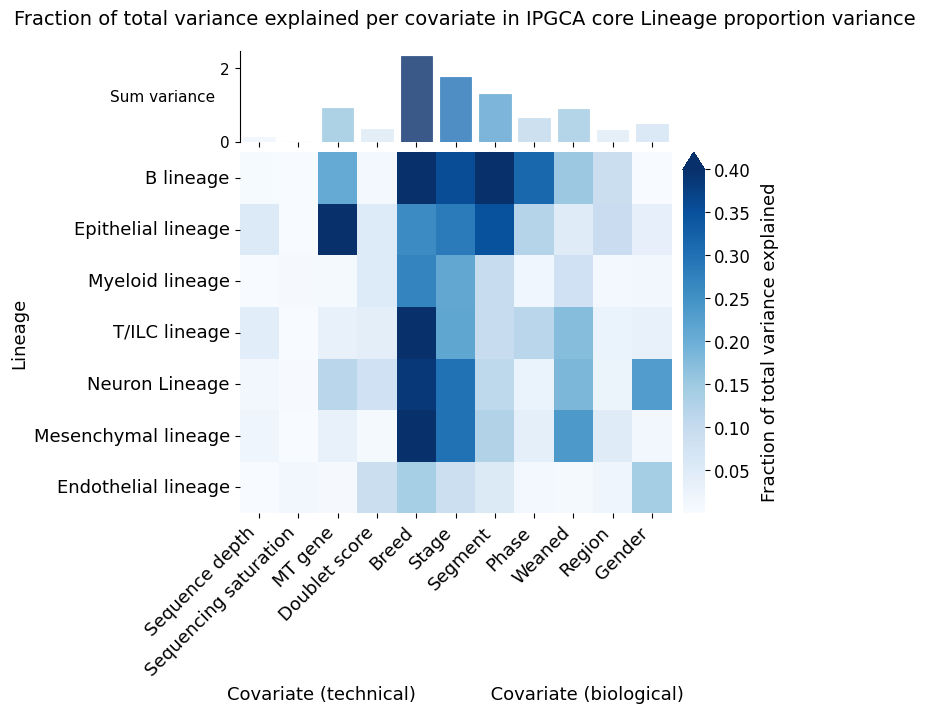

协变量总和统计:
Breed                    2.345
Stage                    1.753
Segment                  1.296
MT gene                  0.922
Weaned                   0.883
Phase                    0.642
Gender                   0.466
Doublet score            0.337
Region                   0.312
Sequence depth           0.135
Sequencing saturation    0.021
dtype: float64

解释方差最多的协变量: Breed (总和: 2.345)


In [56]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import copy
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 设置参数
fz = 13  # fontsize
cmap = copy.copy(cm.get_cmap("Blues"))  # select color map
cmap.set_bad("grey")  # set masked color to grey instead of white
vmax = 0.4
title = "Fraction of total variance"
title_no_spaces = title.replace(" ", "_")

# 计算每个协变量的总和（用于条形图）
covariate_sums = vars_expl_to_plot.astype(float).sum(axis=0, skipna=True)

# 创建图形和子图布局
fig = plt.figure(figsize=(6, 6))
gs = GridSpec(3, 2, figure=fig, height_ratios=[1, 0.05, 4], width_ratios=[20, 1], 
              hspace=0.02, wspace=0.05)

# 创建条形图子图（上方）
ax_bar = fig.add_subplot(gs[0, 0])
# 创建热图子图（下方）
ax_heatmap = fig.add_subplot(gs[2, 0])
# 创建颜色条子图（右侧）
ax_cbar = fig.add_subplot(gs[2, 1])

# 绘制热图（先画热图以获取正确的x轴位置）
sns.heatmap(
    vars_expl_to_plot.astype(float),
    ax=ax_heatmap,
    vmax=vmax,
    cbar_ax=ax_cbar,
    cbar_kws={"extend": "max"},
    cmap=cmap,
)

# 获取热图的x轴刻度位置（seaborn热图的刻度在0.5, 1.5, 2.5...位置）
heatmap_xticks = ax_heatmap.get_xticks()

# 为条形图创建基于值大小的Blues颜色映射
norm = Normalize(vmin=covariate_sums.min(), vmax=covariate_sums.max())
sm = ScalarMappable(norm=norm, cmap=plt.cm.Blues)
bar_colors = [sm.to_rgba(value) for value in covariate_sums.values]

# 绘制条形图，使用与热图相同的x轴位置
bars = ax_bar.bar(heatmap_xticks, covariate_sums.values, 
                  width=0.8, color=bar_colors, alpha=0.8, 
                  edgecolor=bar_colors, linewidth=0.5)

# 设置条形图样式，使用与热图相同的x轴范围和刻度
ax_bar.set_xlim(ax_heatmap.get_xlim())
ax_bar.set_xticks(heatmap_xticks)
ax_bar.set_xticklabels([])  # 不显示x轴标签，因为热图会显示
ax_bar.set_ylabel('Sum variance', fontsize=fz-2, rotation=0, 
                  ha='right', va='center')
ax_bar.tick_params(axis='y', labelsize=fz-2)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)


# 设置热图样式
ax_heatmap.set_xticklabels(ax_heatmap.get_xmajorticklabels(), fontsize=fz, rotation=45, ha='right')
ax_heatmap.set_yticklabels(ax_heatmap.get_ymajorticklabels(), fontsize=fz, rotation=0)
ax_heatmap.set_xlabel("Covariate (technical)             Covariate (biological)", fontsize=fz)
ax_heatmap.set_ylabel("Lineage", fontsize=fz)

# 设置颜色条
ax_cbar.set_ylabel(f"{title} explained", fontsize=fz, rotation=90, va='bottom', labelpad=20)
ax_cbar.tick_params(labelsize=fz-1)

# 设置总标题
fig.suptitle(f"{title} explained per covariate in IPGCA core Lineage proportion variance", 
             fontsize=fz+1, y=0.95)

# 确保条形图和热图的x轴完全对齐
ax_bar.set_xlim(ax_heatmap.get_xlim())
ax_bar.set_xticks(ax_heatmap.get_xticks())

# 调整布局
plt.tight_layout()

# 保存图片
plt.savefig('/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/proportion_cov/prop_cov_var.pdf', 
            dpi=300, bbox_inches='tight')
plt.show()

# 打印一些统计信息
print("协变量总和统计:")
print(covariate_sums.sort_values(ascending=False).round(3))
print(f"\n解释方差最多的协变量: {covariate_sums.idxmax()} (总和: {covariate_sums.max():.3f})")

extend

In [3]:
dir_results = "/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/proportion_extend_cov"
dir_figures = "/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/proportion_extend_covfigures/"
path_extend='/disk212/yupf/database/scRNA-seq/NewAtlas/IPGCA_Extend/celltypist_data/extend_conf08.h5ad'

In [4]:
adata = sc.read(path_extend)

In [5]:
depth_extend=pd.read_csv('/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/other_cov/depth_meta_extend.csv')
depth_extend['Sequencing Saturation']= depth_extend['Sequencing Saturation']/100

In [6]:
map3=dict(zip(depth_extend['sample'],depth_extend['Sequencing Saturation']))
adata.obs['Sequencing Saturation'] = adata.obs['Dataset'].map(map3)

In [7]:
adata=adata[adata.obs['Project']!='PRJNA907920']

In [8]:
adata

View of AnnData object with n_obs × n_vars = 398781 × 25238
    obs: 'doublet_score', 'predicted_doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'project', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden_1.0', 'Dataset', 'segment', 'stage', 'age', 'weaned', 'disease', 'gender', 'region', 'breed', 'platform', 'sequence_method', 'Project', 'Lineage', 'leiden_lineage', 'CellType', 'Sequencing Saturation'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'

In [9]:
covariates = [ 'Sequencing Saturation','total_counts','doublet_score',  'pct_counts_mt', 'segment', 'stage','platform', 'sequence_method','weaned', 'phase', 'gender', 'region', 'breed']

In [12]:
# 初始化字典，存储每次回归中包含的样本
samples_included = dict()
cts_to_skip = list()  # 储存样本太少需要跳过的细胞类型

# 计算每个样本中各细胞类型的比例
def calculate_cell_proportions(adata, celltype_col='Lineage', sample_col='project'):
    """
    计算每个样本中各细胞类型的比例
    """
    # 计算每个样本-细胞类型组合的细胞数
    sample_celltype_counts = adata.obs.groupby([sample_col, celltype_col]).size().unstack(fill_value=0)
    
    # 计算每个样本的总细胞数
    sample_total_counts = sample_celltype_counts.sum(axis=1)
    
    # 计算比例
    sample_celltype_proportions = sample_celltype_counts.div(sample_total_counts, axis=0)
    
    return sample_celltype_proportions

# 计算细胞比例
cell_proportions = calculate_cell_proportions(adata, celltype_col='Lineage', sample_col='project')

# 获取所有细胞类型
all_celltypes = cell_proportions.columns.tolist()

print(f"分析 {len(all_celltypes)} 个细胞类型的比例变异...")
print(f"细胞类型: {all_celltypes}")

# covariates = [ 'total_counts','doublet_score','Sequencing_Saturation','pct_counts_mt', 'segment', 'stage', 'weaned', 'phase', 'gender', 'region', 'breed']

# 为每个细胞类型进行回归分析
for celltype in all_celltypes:
    celltype_no_space = celltype.replace(" ", "_").replace("/", "_")
    
    # 初始化存储每个协变量包含样本信息的DataFrame
    samples_included[celltype] = pd.DataFrame(
        index=adata.obs["project"].unique(), columns=covariates
    )
    
    # 检查输出文件是否已存在
    output_file = os.path.join(
        dir_results,
        f"proportion_variance_explained/proportion_variance_explained_{celltype_no_space}.csv"
    )
    
    if not os.path.isfile(output_file):
        print(f"正在分析细胞类型: {celltype}...")
        
        # 获取该细胞类型的比例数据
        celltype_proportions = cell_proportions[celltype]
        
        # 检查有足够细胞的样本数量
        # 这里我们检查比例大于某个阈值(如0.001)的样本数
        min_proportion_threshold = 0.001  # 可根据需要调整
        valid_samples = celltype_proportions[celltype_proportions > min_proportion_threshold]
        
        if len(valid_samples) < min_n_samples:
            print(f"细胞类型 {celltype} 在足够样本中的比例太低 (只有{len(valid_samples)}个样本). 跳过.")
            cts_to_skip.append(celltype)
            continue
        
        # 创建样本级别的数据框，包含比例和协变量
        sample_df = pd.DataFrame(index=valid_samples.index)
        sample_df['proportion'] = valid_samples
        
        # 添加协变量信息
        for cov in covariates:
            if cov in ['total_counts', 'pct_counts_mt','doublet_score']:
                # 对于细胞级别的协变量，取样本内的平均值
                sample_means = adata.obs.groupby('project')[cov].mean()
                sample_df[cov] = sample_means.reindex(sample_df.index)
            else:
                # 对于样本级别的协变量，直接使用
                sample_covariates = adata.obs.groupby('project')[cov].first()
                sample_df[cov] = sample_covariates.reindex(sample_df.index)
        
        # 过滤掉总细胞数少于最小要求的样本
        sample_cell_counts = adata.obs.groupby('project').size()
        sample_df['n_cells'] = sample_cell_counts.reindex(sample_df.index)
        sample_df = sample_df.loc[sample_df.n_cells >= min_n_cells].copy()
        
        # 再次检查样本数量
        if sample_df.shape[0] < min_n_samples:
            print(f"过滤后只有 {sample_df.shape[0]} 个样本可用于 {celltype}. 跳过.")
            cts_to_skip.append(celltype)
            continue
        
        # 初始化存储方差解释结果的Series
        var_explained = pd.Series(index=covariates + ["overall"], dtype=float)
        
        # 获取比例数据作为因变量
        y_true_unfiltered = sample_df['proportion'].values
        
        # 存储总方差
        var_explained['overall'] = np.var(y_true_unfiltered)
        
        # 对每个协变量进行线性回归
        for cov in covariates:
            # 获取协变量数据
            x = sample_df[cov].values.copy()
            x_samples = sample_df.index
            
            # 检查缺失值
            x_nans = np.vectorize(utils2.check_if_nan)(x)  # 假设utils2.check_if_nan函数存在
            # 如果没有utils2，可以用这个简单版本：
            # x_nans = pd.isna(x)
            
            # 过滤掉缺失值
            x = x[~x_nans]
            
            if len(x) < 2:
                var_explained[cov] = np.nan
                continue
            
            # 过滤样本和因变量
            x_samples = x_samples[~x_nans]
            samples_included[celltype][cov] = samples_included[celltype].index.isin(x_samples.tolist())
            y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
            
            # 准备自变量用于线性回归
            if x.dtype in ["float32", "float", "float64"]:
                x = x.reshape(-1, 1)
                print(f"将 {cov} 作为连续变量处理")
            else:
                # 分类变量处理
                if len(set(x)) == 1:
                    var_explained[cov] = np.nan
                    continue
                
                print(f"将 {cov} 转换为哑变量")
                x = pd.get_dummies(x, drop_first=True)
            
            # 执行线性回归
            try:
                lrf = LinearRegression(fit_intercept=True).fit(x, y_true)
                y_pred = lrf.predict(x)
                var_explained[cov] = np.var(y_pred)
            except Exception as e:
                print(f"回归失败 for {cov}: {e}")
                var_explained[cov] = np.nan
        
        # 计算方差解释比例
        total_variance_explained = var_explained.copy()
        total_variance_explained_fractions = total_variance_explained / total_variance_explained["overall"]
        
        # 按解释方差大小排序
        total_variance_explained_fractions = total_variance_explained_fractions.drop('overall').sort_values(ascending=False)
        
        # 保存结果
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        total_variance_explained_fractions.to_csv(output_file)
        
        # 保存包含的样本信息
        samples_file = os.path.join(
            dir_results,
            f"proportion_samples_included/proportion_samples_included_{celltype_no_space}.csv"
        )
        os.makedirs(os.path.dirname(samples_file), exist_ok=True)
        samples_included[celltype].to_csv(samples_file)
        
        print(f"完成 {celltype} 的分析")
        print(f"解释方差最多的协变量: {total_variance_explained_fractions.index[0]} "
              f"({total_variance_explained_fractions.iloc[0]:.3f})")

print(f"\n分析完成!")
print(f"跳过的细胞类型 (样本不足): {cts_to_skip}")

/tmp/ipykernel_2631396/1855498481.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_celltype_counts = adata.obs.groupby([sample_col, celltype_col]).size().unstack(fill_value=0)
/tmp/ipykernel_2631396/1855498481.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('project')[cov].first()
/tmp/ipykernel_2631396/1855498481.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s

分析 7 个细胞类型的比例变异...
细胞类型: ['T/ILC lineage', 'Myeloid lineage', 'B lineage', 'Epithelial lineage', 'Mesenchymal lineage', 'Endothelial lineage', 'Neuron lineage']
正在分析细胞类型: T/ILC lineage...
将 Sequencing Saturation 作为连续变量处理
将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 platform 转换为哑变量
将 sequence_method 转换为哑变量
将 weaned 转换为哑变量
将 phase 转换为哑变量
将 gender 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 T/ILC lineage 的分析
解释方差最多的协变量: breed (0.661)
正在分析细胞类型: Myeloid lineage...


/tmp/ipykernel_2631396/1855498481.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_means = adata.obs.groupby('project')[cov].mean()
/tmp/ipykernel_2631396/1855498481.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_means = adata.obs.groupby('project')[cov].mean()
/tmp/ipykernel_2631396/1855498481.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_means = adata.obs.groupby('project')[cov].me

将 Sequencing Saturation 作为连续变量处理
将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 platform 转换为哑变量
将 sequence_method 转换为哑变量
将 weaned 转换为哑变量
将 phase 转换为哑变量
将 gender 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 Myeloid lineage 的分析
解释方差最多的协变量: segment (0.335)
正在分析细胞类型: B lineage...
将 Sequencing Saturation 作为连续变量处理
将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 platform 转换为哑变量
将 sequence_method 转换为哑变量
将 weaned 转换为哑变量
将 phase 转换为哑变量


/tmp/ipykernel_2631396/1855498481.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('project')[cov].first()
/tmp/ipykernel_2631396/1855498481.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('project')[cov].first()
/tmp/ipykernel_2631396/1855498481.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('

将 gender 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 B lineage 的分析
解释方差最多的协变量: segment (0.486)
正在分析细胞类型: Epithelial lineage...
将 Sequencing Saturation 作为连续变量处理
将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 platform 转换为哑变量
将 sequence_method 转换为哑变量
将 weaned 转换为哑变量
将 phase 转换为哑变量
将 gender 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 Epithelial lineage 的分析
解释方差最多的协变量: breed (0.941)
正在分析细胞类型: Mesenchymal lineage...


/tmp/ipykernel_2631396/1855498481.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('project')[cov].first()
/tmp/ipykernel_2631396/1855498481.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_cell_counts = adata.obs.groupby('project').size()
/tmp/ipykernel_2631396/1855498481.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('proje

将 Sequencing Saturation 作为连续变量处理
将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 platform 转换为哑变量
将 sequence_method 转换为哑变量
将 weaned 转换为哑变量
将 phase 转换为哑变量
将 gender 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 Mesenchymal lineage 的分析
解释方差最多的协变量: stage (0.495)
正在分析细胞类型: Endothelial lineage...
将 Sequencing Saturation 作为连续变量处理
将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 platform 转换为哑变量
将 sequence_method 转换为哑变量
将 weaned 转换为哑变量
将 phase 转换为哑变量
将 gender 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 Endothelial lineage 的分析
解释方差最多的协变量: segment (0.752)


/tmp/ipykernel_2631396/1855498481.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('project')[cov].first()
/tmp/ipykernel_2631396/1855498481.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_means = adata.obs.groupby('project')[cov].mean()
/tmp/ipykernel_2631396/1855498481.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_means = adata.obs.groupby('project')[c

正在分析细胞类型: Neuron lineage...
将 Sequencing Saturation 作为连续变量处理
将 total_counts 作为连续变量处理
将 doublet_score 作为连续变量处理
将 pct_counts_mt 作为连续变量处理
将 segment 转换为哑变量
将 stage 转换为哑变量
将 platform 转换为哑变量
将 sequence_method 转换为哑变量
将 weaned 转换为哑变量
将 phase 转换为哑变量
将 gender 转换为哑变量
将 region 转换为哑变量
将 breed 转换为哑变量
完成 Neuron lineage 的分析
解释方差最多的协变量: stage (0.655)

分析完成!
跳过的细胞类型 (样本不足): []


/tmp/ipykernel_2631396/1855498481.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('project')[cov].first()
/tmp/ipykernel_2631396/1855498481.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('project')[cov].first()
/tmp/ipykernel_2631396/1855498481.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_covariates = adata.obs.groupby('

In [13]:
# 定义要分析的细胞类型列表（不再包括whole_atlas，因为比例分析是针对单个细胞类型的）
celltypes = sorted(adata.obs.Lineage.unique())

# 导入第一个细胞类型的方差解释比例文件，获取协变量列表（用于初始化DataFrame结构）
first_celltype = [ct for ct in celltypes if ct not in cts_to_skip][0]
first_celltype_no_space = first_celltype.replace(" ", "_").replace("/", "_")

vef_df_template = pd.read_csv(
    os.path.join(
        dir_results,
        f"proportion_variance_explained/proportion_variance_explained_{first_celltype_no_space}.csv",
    ),
    index_col=0,
).rename(columns={"0": "proportion_variance_explained"})

# 初始化空的DataFrame存储所有细胞类型的方差解释比例
# 行是细胞类型，列是协变量
vars_expl = pd.DataFrame(
    index=[ct for ct in celltypes if ct not in cts_to_skip], 
    columns=vef_df_template.index
)

# 初始化空字典存储每个细胞类型-协变量对包含的样本信息
samples_included = dict()

# 遍历所有细胞类型
for celltype in celltypes:
    if celltype not in cts_to_skip:
        # 替换细胞类型名称中的空格和斜杠，用于文件命名
        celltype_no_space = celltype.replace(" ", "_").replace("/", "_")
        
        print(f"正在导入 {celltype} 的结果...")
        
        # 导入方差解释比例
        try:
            vef_df = pd.read_csv(
                os.path.join(
                    dir_results,
                    f"proportion_variance_explained/proportion_variance_explained_{celltype_no_space}.csv",
                ),
                index_col=0,
            ).rename(columns={"0": "proportion_variance_explained"})
            
            # 将值存储到总览DataFrame中
            # 确保协变量顺序一致
            for cov in vef_df.index:
                if cov in vars_expl.columns:
                    vars_expl.loc[celltype, cov] = vef_df.loc[cov, 'proportion_variance_explained']
            
        except FileNotFoundError:
            print(f"警告: 未找到 {celltype} 的方差解释文件")
            continue
        except Exception as e:
            print(f"导入 {celltype} 的方差解释文件时出错: {e}")
            continue
        
        # 导入该细胞类型每个协变量包含的样本信息
        try:
            samples_included[celltype] = pd.read_csv(
                os.path.join(
                    dir_results, 
                    f"proportion_samples_included/proportion_samples_included_{celltype_no_space}.csv"
                ),
                index_col=0,
            )
        except FileNotFoundError:
            print(f"警告: 未找到 {celltype} 的样本包含信息文件")
            samples_included[celltype] = pd.DataFrame()  # 创建空DataFrame作为占位符
        except Exception as e:
            print(f"导入 {celltype} 的样本包含文件时出错: {e}")
            samples_included[celltype] = pd.DataFrame()

print(f"成功导入 {len([ct for ct in celltypes if ct not in cts_to_skip])} 个细胞类型的结果")

# 显示结果概览
print("\n方差解释比例概览 (前5个协变量):")
print(vars_expl.iloc[:, :5].round(3))

# 找出每个细胞类型解释方差最多的协变量
print("\n每个细胞类型解释方差最多的协变量:")
for celltype in vars_expl.index:
    celltype_results = vars_expl.loc[celltype].dropna()
    if len(celltype_results) > 0:
        top_covariate = celltype_results.idxmax()
        top_variance = celltype_results.max()
        print(f"{celltype}: {top_covariate} ({top_variance:.3f})")

# 保存汇总结果
summary_output_file = os.path.join(dir_results, "proportion_variance_explained_summary.csv")
vars_expl.to_csv(summary_output_file)
print(f"\n结果已保存至: {summary_output_file}")

# 可选：创建样本数量统计
print("\n样本数量统计:")
sample_counts_summary = pd.DataFrame(
    index=vars_expl.index, 
    columns=vars_expl.columns
)

for celltype in samples_included.keys():
    if celltype in sample_counts_summary.index and not samples_included[celltype].empty:
        for cov in samples_included[celltype].columns:
            if cov in sample_counts_summary.columns:
                # 计算该细胞类型-协变量组合中包含的样本数
                n_samples = samples_included[celltype][cov].sum() if samples_included[celltype][cov].dtype == bool else len(samples_included[celltype][cov].dropna())
                sample_counts_summary.loc[celltype, cov] = n_samples

# 保存样本数量统计
sample_counts_file = os.path.join(dir_results, "proportion_sample_counts_summary.csv")
sample_counts_summary.to_csv(sample_counts_file)
print(f"样本数量统计已保存至: {sample_counts_file}")

正在导入 B lineage 的结果...
正在导入 Endothelial lineage 的结果...
正在导入 Epithelial lineage 的结果...
正在导入 Mesenchymal lineage 的结果...
正在导入 Myeloid lineage 的结果...
正在导入 Neuron lineage 的结果...
正在导入 T/ILC lineage 的结果...
成功导入 7 个细胞类型的结果

方差解释比例概览 (前5个协变量):
                      segment total_counts     stage    gender    region
B lineage            0.485911     0.353905  0.224132  0.200005  0.138969
Endothelial lineage  0.752478     0.056687  0.473027  0.190389  0.622324
Epithelial lineage   0.406904     0.053553  0.762907  0.874505  0.029203
Mesenchymal lineage  0.391107     0.057001  0.495317  0.337212  0.259184
Myeloid lineage      0.334735     0.007781  0.151174  0.132973  0.066052
Neuron lineage       0.220871     0.113391  0.654966  0.642193  0.020885
T/ILC lineage        0.348596     0.110769  0.365651  0.416177  0.040691

每个细胞类型解释方差最多的协变量:
B lineage: segment (0.486)
Endothelial lineage: segment (0.752)
Epithelial lineage: breed (0.941)
Mesenchymal lineage: stage (0.495)
Myeloid lineage: segment (0.33

In [57]:
vars_expl=pd.read_csv('/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/proportion_extend_cov/proportion_variance_explained_summary.csv',index_col=0)

In [14]:
cts_ordered=[
    'B lineage',
    'Epithelial lineage',
     'Myeloid lineage',
    'T/ILC lineage',
    # 'Neuron Lineage',
 'Mesenchymal lineage',
 'Endothelial lineage']

In [15]:
technical_covariates = [
    'Sequencing Saturation',
    'total_counts',
    'pct_counts_mt',
    'doublet_score',
    'platform', 
    'sequence_method'
]
# specify bio covariates to show
bio_covariates = [
     'breed','stage', 'segment','phase','weaned', 'region', 'gender'
       
]
# order covariates by how much varaince they explain in the Whole atlas,
# in the integrated embedding (but keep technical vs bio distinction)
# vars_expl.sort_values(by="Whole atlas", axis=1, ascending=False, inplace=True)
# technical_covariates = [cov for cov in vars_expl.columns if cov in technical_covariates]
# bio_covariates = [cov for cov in vars_expl.columns if cov in bio_covariates]
# now re-order vars_expl:
vars_expl = vars_expl.loc[cts_ordered,
    technical_covariates + bio_covariates,
]

In [16]:
vars_expl_to_plot = vars_expl.copy()
# add capitalization
col_remapper = {
    col: (" ".join(col.replace("_", " ").split(" "))).capitalize()
    for col in vars_expl.columns
}
# We re-name some of the categories for clarity in the paper:
renaming = {
    'Sequencing Saturation': "Sequencing saturation",
    "pct_counts_mt": "MT gene",
    "total_counts": "Sequence depth",
    "doublet_score": "Doublet score",
}
col_remapper.update(renaming)
# now rename:
vars_expl_to_plot.rename(columns=col_remapper, inplace=True)
# and remove dataset from figure
# vars_expl_to_plot.drop(columns="project", inplace=True)

/tmp/ipykernel_2631396/3572216821.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = copy.copy(cm.get_cmap("Blues"))  # select color map
/tmp/ipykernel_2631396/3572216821.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


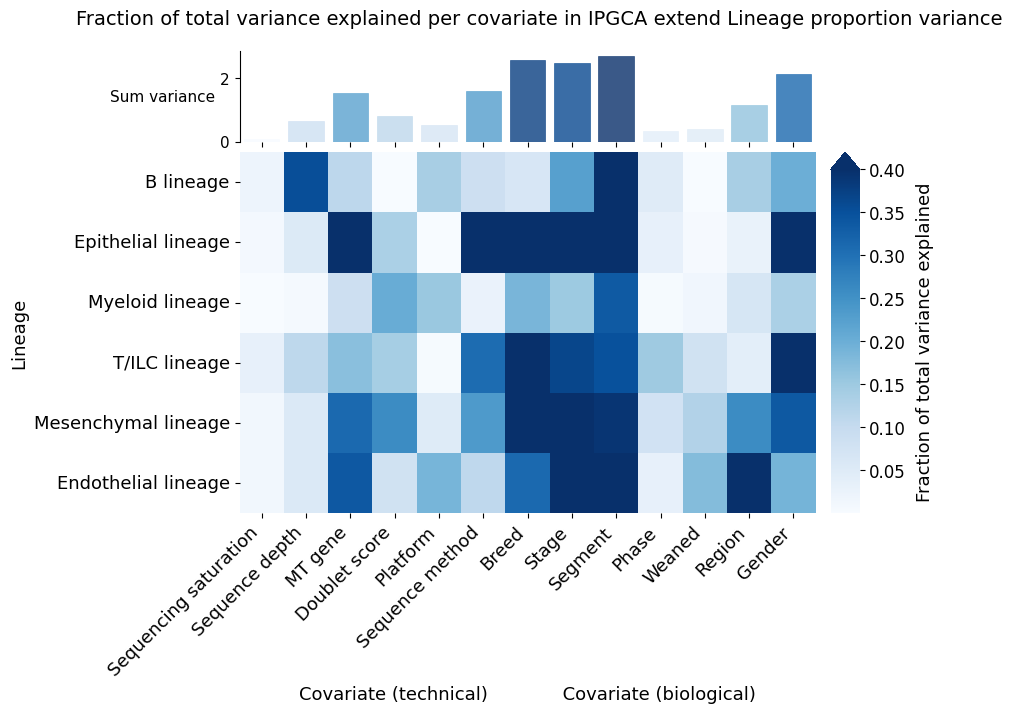

协变量总和统计:
Segment                  2.720
Breed                    2.566
Stage                    2.472
Gender                   2.151
Sequence method          1.606
MT gene                  1.546
Region                   1.156
Doublet score            0.815
Sequence depth           0.640
Platform                 0.537
Weaned                   0.399
Phase                    0.349
Sequencing saturation    0.091
dtype: float64

解释方差最多的协变量: Segment (总和: 2.720)


In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import copy
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 设置参数
fz = 13  # fontsize
cmap = copy.copy(cm.get_cmap("Blues"))  # select color map
cmap.set_bad("grey")  # set masked color to grey instead of white
vmax = 0.4
title = "Fraction of total variance"
title_no_spaces = title.replace(" ", "_")

# 计算每个协变量的总和（用于条形图）
covariate_sums = vars_expl_to_plot.astype(float).sum(axis=0, skipna=True)

# 创建图形和子图布局
fig = plt.figure(figsize=(8, 6))
gs = GridSpec(3, 2, figure=fig, height_ratios=[1, 0.05, 4], width_ratios=[20, 1], 
              hspace=0.02, wspace=0.05)

# 创建条形图子图（上方）
ax_bar = fig.add_subplot(gs[0, 0])
# 创建热图子图（下方）
ax_heatmap = fig.add_subplot(gs[2, 0])
# 创建颜色条子图（右侧）
ax_cbar = fig.add_subplot(gs[2, 1])

# 绘制热图（先画热图以获取正确的x轴位置）
sns.heatmap(
    vars_expl_to_plot.astype(float),
    ax=ax_heatmap,
    vmax=vmax,
    cbar_ax=ax_cbar,
    cbar_kws={"extend": "max"},
    cmap=cmap,
)

# 获取热图的x轴刻度位置（seaborn热图的刻度在0.5, 1.5, 2.5...位置）
heatmap_xticks = ax_heatmap.get_xticks()

# 为条形图创建基于值大小的Blues颜色映射
norm = Normalize(vmin=covariate_sums.min(), vmax=covariate_sums.max())
sm = ScalarMappable(norm=norm, cmap=plt.cm.Blues)
bar_colors = [sm.to_rgba(value) for value in covariate_sums.values]

# 绘制条形图，使用与热图相同的x轴位置
bars = ax_bar.bar(heatmap_xticks, covariate_sums.values, 
                  width=0.8, color=bar_colors, alpha=0.8, 
                  edgecolor=bar_colors, linewidth=0.5)

# 设置条形图样式，使用与热图相同的x轴范围和刻度
ax_bar.set_xlim(ax_heatmap.get_xlim())
ax_bar.set_xticks(heatmap_xticks)
ax_bar.set_xticklabels([])  # 不显示x轴标签，因为热图会显示
ax_bar.set_ylabel('Sum variance', fontsize=fz-2, rotation=0, 
                  ha='right', va='center')
ax_bar.tick_params(axis='y', labelsize=fz-2)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)


# 设置热图样式
ax_heatmap.set_xticklabels(ax_heatmap.get_xmajorticklabels(), fontsize=fz, rotation=45, ha='right')
ax_heatmap.set_yticklabels(ax_heatmap.get_ymajorticklabels(), fontsize=fz, rotation=0)
ax_heatmap.set_xlabel("Covariate (technical)             Covariate (biological)", fontsize=fz)
ax_heatmap.set_ylabel("Lineage", fontsize=fz)

# 设置颜色条
ax_cbar.set_ylabel(f"{title} explained", fontsize=fz, rotation=90, va='bottom', labelpad=20)
ax_cbar.tick_params(labelsize=fz-1)

# 设置总标题
fig.suptitle(f"{title} explained per covariate in IPGCA extend Lineage proportion variance", 
             fontsize=fz+1, y=0.95)

# 确保条形图和热图的x轴完全对齐
ax_bar.set_xlim(ax_heatmap.get_xlim())
ax_bar.set_xticks(ax_heatmap.get_xticks())

# 调整布局
plt.tight_layout()

# 保存图片
plt.savefig('/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/proportion_extend_cov/prop_cov_var_extend.pdf', 
            dpi=300, bbox_inches='tight')
plt.show()

# 打印一些统计信息
print("协变量总和统计:")
print(covariate_sums.sort_values(ascending=False).round(3))
print(f"\n解释方差最多的协变量: {covariate_sums.idxmax()} (总和: {covariate_sums.max():.3f})")

summary

In [3]:
df1=pd.read_csv('/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/proportion_cov/proportion_variance_explained_summary.csv')
df1

,Unnamed: 0,segment,breed,stage,phase,pct_counts_mt,weaned,region,doublet_score,total_counts,gender,Sequencing_Saturation
0,B lineage,0.463104,0.451979,0.355015,0.314813,0.207789,0.153018,0.091954,0.010738,0.003840,0.000658,0.000484
1,Endothelial lineage,0.053917,0.140098,0.088067,0.010623,0.006261,0.007739,0.018555,0.091375,0.000920,0.141590,0.011551
2,Epithelial lineage,0.349440,0.258501,0.285318,0.120330,0.523139,0.048795,0.093186,0.052459,0.055406,0.033433,0.000015
3,Mesenchymal lineage,0.126488,0.427086,0.299362,0.037586,0.030460,0.236702,0.047507,0.007632,0.018447,0.013229,0.001104
4,Myeloid lineage,0.095721,0.270570,0.211654,0.014572,0.006781,0.081962,0.009126,0.051715,0.000021,0.013669,0.005643
5,Neuron Lineage,0.110753,0.387258,0.298570,0.027133,0.117040,0.182925,0.024999,0.082703,0.012015,0.232793,0.002385
6,Red blood,0.785413,0.007278,0.110096,0.379750,0.357287,NaN,0.009565,0.007280,0.000032,NaN,0.435627
7,T/ILC lineage,0.096353,0.409616,0.214571,0.117134,0.030556,0.172277,0.026921,0.040291,0.044649,0.030355,0.000313


In [4]:
df2=pd.read_csv('/disk212/yupf/database/scRNA-seq/NewAtlas/cov_variance/proportion_extend_cov/proportion_variance_explained_summary.csv')
df2

,Unnamed: 0,total_counts,segment,stage,breed,gender,platform,region,pct_counts_mt,sequence_method,doublet_score,phase,Sequencing Saturation,weaned
0,B lineage,0.345033,0.314705,0.310641,0.115353,0.104108,0.093356,0.093356,0.077740,0.062472,0.054815,0.040714,0.034663,0.002339
1,Endothelial lineage,0.048813,0.750406,0.281548,0.348019,0.217945,0.198589,0.631577,0.354082,0.123118,0.109038,0.022550,0.023210,0.182232
2,Epithelial lineage,0.034610,0.368369,0.752166,0.981466,0.881952,0.002033,0.040713,0.526562,0.844891,0.147079,0.020410,0.001845,0.002187
3,Mesenchymal lineage,0.043482,0.394149,0.448383,0.439021,0.358365,0.060447,0.274634,0.326056,0.253637,0.267350,0.047357,0.021455,0.132501
4,Myeloid lineage,0.006015,0.325154,0.077417,0.180991,0.127574,0.151772,0.064470,0.078503,0.026644,0.110240,0.004439,0.000635,0.014596
5,Neuron lineage,0.066231,0.144923,0.656941,0.703225,0.666652,0.000040,0.032662,0.522976,0.655712,0.168460,0.040867,0.017393,0.000013
6,T/ILC lineage,0.119130,0.178140,0.395507,0.715457,0.354946,0.012856,0.058137,0.170460,0.291372,0.284836,0.066063,0.039865,0.082359


In [6]:
df2.sum()

Unnamed: 0               B lineageEndothelial lineageEpithelial lineage...
total_counts                                                      0.663314
segment                                                           2.475845
stage                                                             2.922603
breed                                                             3.483531
gender                                                            2.711541
platform                                                          0.519092
region                                                            1.195548
pct_counts_mt                                                     2.056379
sequence_method                                                   2.257846
doublet_score                                                     1.141819
phase                                                               0.2424
Sequencing Saturation                                             0.139065
weaned                   